# Building a Multi-Agent Supervisor Workflow with LangGraph and Snowflake

This notebook demonstrates how to build a **multi-agent supervisor architecture** using LangGraph and Snowflake Cortex Agents. The workflow consists of:

- **Supervisor**: An AI coordinator that routes queries to specialized agents and synthesizes their responses
- **Content Agent**: Handles customer feedback, sentiment analysis, and communication intelligence
- **Data Analyst Agent**: Handles customer behavior, business metrics, and predictive analytics
- **Research Agent**: Handles market intelligence, strategic analysis, and competitive insights

## Architecture Overview

```
START → Supervisor (Route) → Specialized Agent → Supervisor (Synthesize) → END
```

The supervisor makes two passes:
1. **Routing Pass**: Analyzes the query and routes to the appropriate agent
2. **Synthesis Pass**: Combines agent output into an executive summary


## Step 1: Install and Import Dependencies

First, let's import all the necessary libraries. We'll need:
- **LangChain Core**: For message types and prompt templates
- **LangChain Snowflake**: For Snowflake-specific integrations (ChatSnowflake, SnowflakeCortexAgent)
- **LangGraph**: For building the stateful workflow graph


In [1]:
import os
import json
from pathlib import Path
from typing import Dict, List, Optional

# LangChain imports
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate

# Snowflake LangChain integration
from langchain_snowflake import ChatSnowflake, SnowflakeCortexAgent
from langchain_snowflake import create_session_from_env

# LangGraph imports
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict, Annotated

# Load environment variables
from dotenv import load_dotenv
load_dotenv(override=True)  # Force reload to override any cached values

# Debug: Print account info to verify correct format
print(f"🔍 SNOWFLAKE_ACCOUNT = {os.getenv('SNOWFLAKE_ACCOUNT')}")
print(f"🔍 SNOWFLAKE_USER = {os.getenv('SNOWFLAKE_USER')}")
print("✅ All dependencies imported successfully!")


✅ All dependencies imported successfully!


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/langchain_snowflake/chat_models/base.py:26: UserWarning: Field name "schema" in "ChatSnowflake" shadows an attribute in parent "BaseChatModel"
  class ChatSnowflake(


## Step 2: Define the Workflow State

LangGraph uses a **state** object that flows through the graph. We'll use the built-in `MessagesState` which provides:
- A `messages` list that accumulates all messages in the conversation
- Automatic message deduplication and ordering

The state is shared across all nodes and gets updated as the workflow progresses.


In [2]:
# Use LangGraph's built-in MessagesState
# This is equivalent to: TypedDict with {"messages": Annotated[List[BaseMessage], add_messages]}
State = MessagesState

print("✅ State defined using MessagesState")
print(f"   State type: {State}")
print(f"   This state will track all messages as they flow through the workflow")


✅ State defined using MessagesState
   State type: <class 'langgraph.graph.message.MessagesState'>
   This state will track all messages as they flow through the workflow


## Step 3: Create Snowflake Session

We need to establish a connection to Snowflake. The `create_session_from_env()` function reads credentials from environment variables:
- `SNOWFLAKE_ACCOUNT`
- `SNOWFLAKE_USER`
- `SNOWFLAKE_PASSWORD`
- `SNOWFLAKE_DATABASE`
- `SNOWFLAKE_SCHEMA`
- `SNOWFLAKE_WAREHOUSE`

Make sure you have a `.env` file with these variables set.


In [3]:
# Create Snowflake session from environment variables
try:
    session = create_session_from_env()
    
    # Get database and schema, stripping any quotes that Snowflake might add
    current_database = session.get_current_database().strip('"')
    current_schema = session.get_current_schema().strip('"')
    
    print("✅ Snowflake session created successfully!")
    print(f"   Database: {current_database}")
    print(f"   Schema: {current_schema}")
    
except Exception as e:
    print(f"❌ Snowflake connection failed: {e}")
    print("   Please check your .env file and Snowflake credentials")
    raise


✅ Snowflake session created successfully!
   Database: CUSTOMER_INTELLIGENCE_DB
   Schema: PUBLIC


## Step 4: Initialize the Supervisor Model

The **Supervisor** is the brain of our multi-agent system. It uses Snowflake's Cortex LLM service (`ChatSnowflake`) to:
1. Analyze incoming queries
2. Route them to the appropriate specialized agent
3. Synthesize the agent's response into an executive summary

We use `claude-4-sonnet` with low temperature (0.1) for consistent, deterministic routing decisions.


In [4]:
# Initialize the supervisor model using Snowflake Cortex
supervisor_model = ChatSnowflake(
    session=session,
    model="claude-4-sonnet",  # Claude 4 Sonnet via Snowflake Cortex
    temperature=0.1,          # Low temperature for consistent routing
    max_tokens=2000           # Limit response length
)

print("✅ Supervisor model initialized!")
print(f"   Model: claude-4-sonnet")
print(f"   Temperature: 0.1 (deterministic)")
print(f"   Max tokens: 2000")


✅ Supervisor model initialized!
   Model: claude-4-sonnet
   Temperature: 0.1 (deterministic)
   Max tokens: 2000


## Step 5: Initialize Specialized Cortex Agents

Now we initialize our three specialized **Snowflake Cortex Agents**. These agents are pre-configured in Snowflake with access to specific tools, data sources, and instructions.

Each agent is specialized for a different domain:
| Agent | Specialization |
|-------|----------------|
| **CONTENT_AGENT** | Customer feedback, sentiment analysis, support tickets |
| **DATA_ANALYST_AGENT** | Metrics, behavior patterns, churn prediction, analytics |
| **RESEARCH_AGENT** | Market research, competitive analysis, strategic insights |


In [5]:
# Agent configuration - agents are stored in the SNOWFLAKE_INTELLIGENCE.AGENTS schema
AGENT_DATABASE = "SNOWFLAKE_INTELLIGENCE"
AGENT_SCHEMA = "AGENTS"

# Initialize Content Agent - Customer feedback and sentiment specialist
content_agent = SnowflakeCortexAgent(
    session=session,
    name="CONTENT_AGENT",
    database=AGENT_DATABASE,
    schema=AGENT_SCHEMA,
    description="Customer feedback, sentiment analysis, and communication intelligence specialist",
    verify_ssl=False  # Required due to hostname SSL certificate mismatch
)
print("✅ CONTENT_AGENT initialized")

# Initialize Data Analyst Agent - Metrics and analytics specialist
data_analyst_agent = SnowflakeCortexAgent(
    session=session,
    name="DATA_ANALYST_AGENT",
    database=AGENT_DATABASE,
    schema=AGENT_SCHEMA,
    description="Customer behavior, business metrics, and predictive analytics specialist",
    verify_ssl=False  # Required due to hostname SSL certificate mismatch
)
print("✅ DATA_ANALYST_AGENT initialized")

# Initialize Research Agent - Market intelligence specialist
research_agent = SnowflakeCortexAgent(
    session=session,
    name="RESEARCH_AGENT",
    database=AGENT_DATABASE,
    schema=AGENT_SCHEMA,
    description="Market intelligence, strategic analysis, and competitive insights specialist",
    verify_ssl=False  # Required due to hostname SSL certificate mismatch
)
print("✅ RESEARCH_AGENT initialized")

print(f"\n📍 All agents loaded from: {AGENT_DATABASE}.{AGENT_SCHEMA}")


✅ CONTENT_AGENT initialized
✅ DATA_ANALYST_AGENT initialized
✅ RESEARCH_AGENT initialized

📍 All agents loaded from: SNOWFLAKE_INTELLIGENCE.AGENTS


## Step 6: Create Supervisor Prompts

The supervisor uses two different prompts depending on its current task:

### 1. Routing Prompt
Used to analyze the user's query and decide which agent should handle it. The output is structured JSON for reliable parsing.

### 2. Synthesis Prompt  
Used after an agent responds to combine findings into a business-friendly executive summary.


In [6]:
# Routing Prompt - Used to select which agent handles the query
routing_prompt = """
You are an Executive AI Assistant supervisor managing three specialized business intelligence agents:

**CONTENT_AGENT**: Customer feedback, sentiment analysis, and communication intelligence
**DATA_ANALYST_AGENT**: Customer behavior, business metrics, and predictive analytics  
**RESEARCH_AGENT**: Market intelligence, strategic analysis, and competitive insights

**CRITICAL INSTRUCTION**: You MUST respond with ONLY a JSON object in this exact format:
{{"next_agent": "AGENT_NAME"}}

**Routing Guidelines:**
- Customer feedback, sentiment, satisfaction, support issues, complaints → CONTENT_AGENT
- Data analysis, metrics, behavior patterns, churn, revenue, analytics → DATA_ANALYST_AGENT  
- Market research, competition, strategy, industry trends → RESEARCH_AGENT

**Examples:**
- "Assess churn risk for customers complaining about API issues" → {{"next_agent": "CONTENT_AGENT"}}
- "Analyze customer behavior patterns for Q3" → {{"next_agent": "DATA_ANALYST_AGENT"}}
- "Research market opportunities in fintech" → {{"next_agent": "RESEARCH_AGENT"}}

**RESPOND WITH ONLY THE JSON - NO OTHER TEXT, NO EXPLANATIONS, NO MARKDOWN**
"""

routing_prompt_template = ChatPromptTemplate.from_messages([
    ("system", routing_prompt),
    ("human", "{input}")
])

print("✅ Routing prompt template created")
print("   Output format: JSON with 'next_agent' key")


✅ Routing prompt template created
   Output format: JSON with 'next_agent' key


In [7]:
# Synthesis Prompt - Used to summarize agent findings
synthesis_prompt = """
You are an Executive AI Assistant synthesizing insights from specialized agents.

**Original Question**: {question}

**Agent Analysis**: {agent_output}

**Instructions**:
1. Extract the key findings and insights from the agent's analysis
2. Present them in a clear, business-friendly format
3. Include specific data points, metrics, and recommendations when available
4. If the agent encountered issues finding data, acknowledge this and suggest alternatives
5. Keep the response concise but comprehensive

**Format your response as**:
- **Summary**: Brief overview of findings
- **Key Insights**: Bullet points of important discoveries  
- **Recommendations**: Actionable next steps
- **Data Gaps** (if any): Note any limitations in the analysis
"""

synthesis_prompt_template = ChatPromptTemplate.from_messages([
    ("system", synthesis_prompt),
    ("human", "Please synthesize the agent's findings into an executive summary.")
])

print("✅ Synthesis prompt template created")
print("   Output format: Structured executive summary")


✅ Synthesis prompt template created
   Output format: Structured executive summary


## Step 7: Create Helper Functions

We need several helper functions to work with the message state:

1. **`get_latest_human_message`**: Extracts the user's query from the message list
2. **`has_agent_response`**: Checks if any specialized agent has already responded
3. **`get_agent_output`**: Retrieves the agent's response for synthesis

These helpers make our node functions cleaner and handle various message formats (including LangGraph Studio's format).


In [8]:
def get_latest_human_message(messages: List[BaseMessage]) -> str:
    """
    Extract the latest human message content from the message list.
    
    Handles multiple formats:
    - Standard HumanMessage objects
    - LangGraph Studio format (list of content blocks)
    - Dict-like messages
    """
    if not messages:
        return ""
        
    for msg in reversed(messages):
        # Handle HumanMessage objects
        if isinstance(msg, HumanMessage):
            content = msg.content
            
            # Handle LangGraph Studio format (list of content blocks)
            if isinstance(content, list):
                for item in content:
                    if isinstance(item, dict) and item.get("type") == "text":
                        return item.get("text", "")
                    elif isinstance(item, str):
                        return item
            return str(content)
        
        # Handle dict-like messages (from LangGraph Studio)
        if isinstance(msg, dict):
            if msg.get("type") == "human" or msg.get("role") == "user":
                content = msg.get("content", "")
                if isinstance(content, list):
                    for item in content:
                        if isinstance(item, dict) and item.get("type") == "text":
                            return item.get("text", "")
                return str(content)
                    
    return ""

print("✅ get_latest_human_message() defined")


✅ get_latest_human_message() defined


In [9]:
# List of agent names for identification
AGENT_NAMES = ["CONTENT_AGENT", "DATA_ANALYST_AGENT", "RESEARCH_AGENT"]

def has_agent_response(messages: List[BaseMessage]) -> bool:
    """
    Check if any specialized agent has already responded in the messages.
    
    This helps the supervisor know whether to route (first pass) 
    or synthesize (second pass).
    """
    for msg in messages:
        if hasattr(msg, 'name') and msg.name in AGENT_NAMES:
            return True
    return False

def get_agent_output(messages: List[BaseMessage]) -> str:
    """
    Get the most recent agent's output from the message list.
    
    Used by the supervisor to synthesize the agent's findings.
    """
    for msg in reversed(messages):
        if hasattr(msg, 'name') and msg.name in AGENT_NAMES:
            return msg.content if hasattr(msg, 'content') else str(msg)
    return ""

print("✅ has_agent_response() defined")
print("✅ get_agent_output() defined")


✅ has_agent_response() defined
✅ get_agent_output() defined


## Step 8: Create Node Functions

Now we define the **node functions** - the actual work units of our graph. Each node:
- Receives the current state
- Performs some action (LLM call, agent invocation, etc.)
- Returns state updates (new messages to add)

### Node Types:
1. **Supervisor Node**: Handles routing AND synthesis (dual-purpose)
2. **Agent Nodes**: Invoke specialized Cortex agents


In [10]:
def supervisor_node(state: State) -> Dict[str, List[BaseMessage]]:
    """
    Supervisor node that handles both routing (first pass) and synthesis (second pass).
    
    Flow:
    1. First pass (no agent response yet): Analyze query and output routing JSON
    2. Second pass (agent has responded): Synthesize findings into executive summary
    """
    print(f"\n{'='*50}")
    print("SUPERVISOR NODE EXECUTING")
    print(f"{'='*50}")
    
    messages = state.get("messages", [])
    print(f"Processing {len(messages)} messages")
    
    # Check if we're in synthesis mode (agent has responded)
    if has_agent_response(messages):
        print("📋 MODE: Synthesis (agent has responded)")
        
        original_question = get_latest_human_message(messages)
        agent_output = get_agent_output(messages)
        
        try:
            # Create synthesis chain and invoke
            synthesis_chain = synthesis_prompt_template | supervisor_model
            response = synthesis_chain.invoke({
                "question": original_question,
                "agent_output": agent_output[:10000]  # Limit to avoid token overflow
            })
            
            content = response.content if hasattr(response, 'content') else str(response)
            print(f"✅ Synthesis completed: {len(content)} characters")
            
            # Return synthesis result with special name for routing
            return {"messages": [AIMessage(content=content, name="supervisor_synthesis")]}
            
        except Exception as e:
            print(f"❌ Synthesis error: {e}")
            return {"messages": [AIMessage(
                content=f"Analysis completed. Raw findings:\n\n{agent_output[:2000]}...",
                name="supervisor_synthesis"
            )]}
    
    # Routing mode - first pass
    print("🔀 MODE: Routing (selecting agent)")
    
    latest_message = get_latest_human_message(messages)
    
    if not latest_message:
        print("⚠️ No human message found")
        return {"messages": [AIMessage(content='{"next_agent": "END"}', name="supervisor_routing")]}
    
    print(f"Analyzing query: {latest_message[:100]}...")
    
    try:
        # Create routing chain and invoke
        routing_chain = routing_prompt_template | supervisor_model
        response = routing_chain.invoke({"input": latest_message})
        
        content = response.content if hasattr(response, 'content') else str(response)
        print(f"✅ Routing decision: {content}")
        
        return {"messages": [AIMessage(content=content, name="supervisor_routing")]}
            
    except Exception as e:
        print(f"❌ Supervisor error: {e}")
        return {"messages": [AIMessage(content='{"next_agent": "END"}', name="supervisor_routing")]}

print("✅ supervisor_node() defined")


✅ supervisor_node() defined


In [11]:
def content_agent_node(state: State) -> Dict[str, List[BaseMessage]]:
    """
    Content Agent node - handles customer feedback and sentiment analysis.
    """
    messages = state["messages"]
    query = get_latest_human_message(messages)
    
    print(f"\n{'='*50}")
    print("CONTENT_AGENT EXECUTING")
    print(f"{'='*50}")
    print(f"Processing: {query[:100]}...")
    
    try:
        result = content_agent.invoke(query)
        response_content = result.get("output", "")
        
        print(f"✅ CONTENT_AGENT completed ({len(response_content)} chars)")
        
        return {"messages": [AIMessage(content=response_content, name="CONTENT_AGENT")]}
        
    except Exception as e:
        print(f"❌ CONTENT_AGENT error: {e}")
        return {"messages": [AIMessage(
            content=f"Error executing CONTENT_AGENT: {str(e)}",
            name="CONTENT_AGENT"
        )]}

print("✅ content_agent_node() defined")


✅ content_agent_node() defined


In [12]:
def data_analyst_agent_node(state: State) -> Dict[str, List[BaseMessage]]:
    """
    Data Analyst Agent node - handles metrics and analytics queries.
    """
    messages = state["messages"]
    query = get_latest_human_message(messages)
    
    print(f"\n{'='*50}")
    print("DATA_ANALYST_AGENT EXECUTING")
    print(f"{'='*50}")
    print(f"Processing: {query[:100]}...")
    
    try:
        result = data_analyst_agent.invoke(query)
        response_content = result.get("output", "")
        
        print(f"✅ DATA_ANALYST_AGENT completed ({len(response_content)} chars)")
        
        return {"messages": [AIMessage(content=response_content, name="DATA_ANALYST_AGENT")]}
        
    except Exception as e:
        print(f"❌ DATA_ANALYST_AGENT error: {e}")
        return {"messages": [AIMessage(
            content=f"Error executing DATA_ANALYST_AGENT: {str(e)}",
            name="DATA_ANALYST_AGENT"
        )]}

print("✅ data_analyst_agent_node() defined")


✅ data_analyst_agent_node() defined


In [13]:
def research_agent_node(state: State) -> Dict[str, List[BaseMessage]]:
    """
    Research Agent node - handles market intelligence and strategic analysis.
    """
    messages = state["messages"]
    query = get_latest_human_message(messages)
    
    print(f"\n{'='*50}")
    print("RESEARCH_AGENT EXECUTING")
    print(f"{'='*50}")
    print(f"Processing: {query[:100]}...")
    
    try:
        result = research_agent.invoke(query)
        response_content = result.get("output", "")
        
        print(f"✅ RESEARCH_AGENT completed ({len(response_content)} chars)")
        
        return {"messages": [AIMessage(content=response_content, name="RESEARCH_AGENT")]}
        
    except Exception as e:
        print(f"❌ RESEARCH_AGENT error: {e}")
        return {"messages": [AIMessage(
            content=f"Error executing RESEARCH_AGENT: {str(e)}",
            name="RESEARCH_AGENT"
        )]}

print("✅ research_agent_node() defined")


✅ research_agent_node() defined


## Step 9: Create the Routing Function

The **routing function** is used by LangGraph's conditional edges. It:
1. Reads the supervisor's routing decision (JSON)
2. Parses the `next_agent` field
3. Returns the name of the next node to execute

This enables dynamic routing based on the supervisor's analysis of each query.


In [14]:
def route_after_supervisor(state: State) -> str:
    """
    Routing function that parses the supervisor's decision and returns the next node.
    
    Returns:
        - "CONTENT_AGENT", "DATA_ANALYST_AGENT", or "RESEARCH_AGENT" for routing
        - "__end__" to terminate the workflow
    """
    messages = state.get("messages", [])
    
    if not messages:
        print("⚠️ No messages found, ending workflow")
        return "__end__"
        
    last_message = messages[-1]
    
    # Check if synthesis is complete (supervisor_synthesis message)
    if hasattr(last_message, 'name') and last_message.name == "supervisor_synthesis":
        print("\n🏁 ROUTING: Synthesis complete, ending workflow")
        return "__end__"
    
    content = last_message.content if hasattr(last_message, 'content') else str(last_message)
    
    # Parse JSON from supervisor's routing response
    next_agent = "END"
    if "{" in content and "}" in content:
        try:
            start = content.find("{")
            end = content.rfind("}") + 1
            json_str = content[start:end]
            decision = json.loads(json_str)
            next_agent = decision.get("next_agent", "END")
        except json.JSONDecodeError:
            pass
    
    print(f"\n🔀 ROUTING: Supervisor decided → {next_agent}")
    
    # Map agent names to node names
    if next_agent == "CONTENT_AGENT":
        return "CONTENT_AGENT"
    elif next_agent == "DATA_ANALYST_AGENT":
        return "DATA_ANALYST_AGENT"
    elif next_agent == "RESEARCH_AGENT":
        return "RESEARCH_AGENT"
    else:
        return "__end__"

print("✅ route_after_supervisor() defined")


✅ route_after_supervisor() defined


## Step 10: Build the Workflow Graph

Now we assemble all the pieces into a **StateGraph**. The graph defines:

1. **Nodes**: The processing units (supervisor + 3 agents)
2. **Edges**: The connections between nodes
3. **Conditional Edges**: Dynamic routing based on state

### Graph Structure:
```
START 
  ↓
supervisor (routing)
  ↓ (conditional)
  ├── CONTENT_AGENT ────────────┐
  ├── DATA_ANALYST_AGENT ───────┼── supervisor (synthesis)
  └── RESEARCH_AGENT ───────────┘        ↓
                                       END
```


In [15]:
# Create the StateGraph with our State type
workflow = StateGraph(State)
print("✅ StateGraph created")

# Add the supervisor node
workflow.add_node("supervisor", supervisor_node)
print("   Added node: supervisor")

# Add the agent nodes
workflow.add_node("CONTENT_AGENT", content_agent_node)
print("   Added node: CONTENT_AGENT")

workflow.add_node("DATA_ANALYST_AGENT", data_analyst_agent_node)
print("   Added node: DATA_ANALYST_AGENT")

workflow.add_node("RESEARCH_AGENT", research_agent_node)
print("   Added node: RESEARCH_AGENT")


✅ StateGraph created
   Added node: supervisor
   Added node: CONTENT_AGENT
   Added node: DATA_ANALYST_AGENT
   Added node: RESEARCH_AGENT


In [16]:
# Define the edges - how nodes connect to each other

# Entry point: START → supervisor
workflow.add_edge(START, "supervisor")
print("✅ Added edge: START → supervisor")

# Conditional edges from supervisor (routing logic)
workflow.add_conditional_edges(
    "supervisor",                    # Source node
    route_after_supervisor,          # Routing function
    {
        "CONTENT_AGENT": "CONTENT_AGENT",
        "DATA_ANALYST_AGENT": "DATA_ANALYST_AGENT", 
        "RESEARCH_AGENT": "RESEARCH_AGENT",
        "__end__": END               # End workflow after synthesis
    }
)
print("✅ Added conditional edges from supervisor")

# All agents route back to supervisor for synthesis
workflow.add_edge("CONTENT_AGENT", "supervisor")
workflow.add_edge("DATA_ANALYST_AGENT", "supervisor")
workflow.add_edge("RESEARCH_AGENT", "supervisor")
print("✅ Added edges: All agents → supervisor (for synthesis)")


✅ Added edge: START → supervisor
✅ Added conditional edges from supervisor
✅ Added edges: All agents → supervisor (for synthesis)


## Step 11: Compile the Workflow

Compiling the graph creates an executable application. The compiled graph:
- Validates the graph structure
- Creates an optimized execution plan
- Returns a runnable object that can be invoked with input


In [17]:
# Compile the workflow into an executable application
app = workflow.compile()

print("✅ Workflow compiled successfully!")
print("\n📊 Workflow Summary:")
print("   • 1 Supervisor node (routing + synthesis)")
print("   • 3 Specialized agent nodes")
print("   • Dynamic routing based on query analysis")
print("   • Flow: START → supervisor → agent → supervisor → END")


✅ Workflow compiled successfully!

📊 Workflow Summary:
   • 1 Supervisor node (routing + synthesis)
   • 3 Specialized agent nodes
   • Dynamic routing based on query analysis
   • Flow: START → supervisor → agent → supervisor → END


## Step 12: Visualize the Graph (Optional)

LangGraph can generate a visual representation of the workflow. This requires the `pygraphviz` or `grandalf` library.


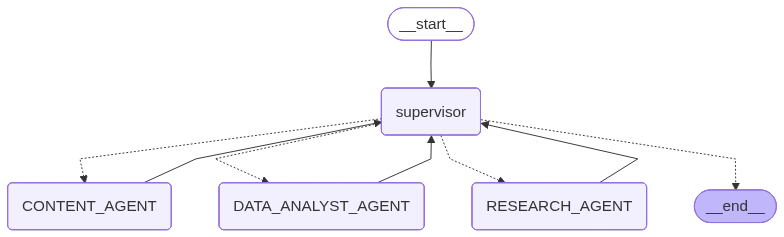

✅ Graph visualization generated


In [18]:
# Try to visualize the graph (requires graphviz)
try:
    from IPython.display import Image, display
    
    # Generate the graph visualization
    graph_image = app.get_graph().draw_mermaid_png()
    display(Image(graph_image))
    print("✅ Graph visualization generated")
except Exception as e:
    print(f"ℹ️ Graph visualization not available: {e}")
    print("   Install pygraphviz or grandalf for visualization support")
    print("\n   Graph structure:")
    print("   START → supervisor → [CONTENT_AGENT | DATA_ANALYST_AGENT | RESEARCH_AGENT] → supervisor → END")


## Step 13: Test the Workflow

Now let's test the workflow with some sample queries! Each query type should be routed to a different agent:

| Query Type | Expected Agent |
|------------|----------------|
| Customer feedback, sentiment, complaints | CONTENT_AGENT |
| Metrics, behavior, churn, analytics | DATA_ANALYST_AGENT |
| Market research, competition, strategy | RESEARCH_AGENT |


In [19]:
# Install TruLens packages (uncomment if needed)
# !pip install trulens trulens-apps-langgraph trulens-providers-cortex trulens-connectors-snowflake -q

# Import TruLens components
from trulens.apps.langgraph import TruGraph
from trulens.connectors.snowflake import SnowflakeConnector
from trulens.providers.cortex import Cortex
from trulens.core.feedback.custom_metric import MetricConfig
from trulens.core.feedback.selector import Selector
from trulens.core.run import Run, RunConfig
import uuid

print("✅ TruLens dependencies imported successfully!")


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/munch/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/trulens/core/utils/imports.py:591: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  return self.imp(name, globals, locals, fromlist, level)


✅ TruLens dependencies imported successfully!


In [20]:
# Connect TruLens to Snowflake for observability
# This uses the same session we created earlier

sf_connector = SnowflakeConnector(snowpark_session=session)
print("✅ Snowflake connector created for TruLens")

# Initialize the Cortex provider for client-side evaluations
# This provider will use Snowflake Cortex LLMs to compute custom metrics
trace_eval_provider = Cortex(
    model_engine="claude-3-5-sonnet",
    snowpark_session=session
)
print("✅ Cortex evaluation provider initialized")
print(f"   Model: claude-3-5-sonnet")


Running the TruLens dashboard requires providing a `password` to the `SnowflakeConnector`.


✅ Snowflake connector created for TruLens
✅ Cortex evaluation provider initialized
   Model: claude-3-5-sonnet


In [21]:
# Define custom client-side metrics using Cortex LLMs
# These metrics evaluate different aspects of the agent's performance

# Plan Quality - Evaluates how well the supervisor routes queries
f_plan_quality = MetricConfig(
    metric_implementation=trace_eval_provider.plan_quality_with_cot_reasons,
    metric_name="Plan Quality",
    selectors={
        "trace": Selector(trace_level=True),
    },
)
print("✅ Plan Quality metric configured")

# Plan Adherence - Checks if the agent follows the routing decision
f_plan_adherence = MetricConfig(
    metric_implementation=trace_eval_provider.plan_adherence_with_cot_reasons,
    metric_name="Plan Adherence",
    selectors={
        "trace": Selector(trace_level=True),
    },
)
print("✅ Plan Adherence metric configured")

# Execution Efficiency - Measures workflow efficiency
f_execution_efficiency = MetricConfig(
    metric_implementation=trace_eval_provider.execution_efficiency_with_cot_reasons,
    metric_name="Execution Efficiency",
    selectors={
        "trace": Selector(trace_level=True),
    },
)
print("✅ Execution Efficiency metric configured")

# Logical Consistency - Verifies consistency across agent responses
f_logical_consistency = MetricConfig(
    metric_implementation=trace_eval_provider.logical_consistency_with_cot_reasons,
    metric_name="Logical Consistency",
    selectors={
        "trace": Selector(trace_level=True),
    },
)
print("✅ Logical Consistency metric configured")


✅ Plan Quality metric configured
✅ Plan Adherence metric configured
✅ Execution Efficiency metric configured
✅ Logical Consistency metric configured


## Step 14: Try Your Own Query

Now it's your turn! Modify the query below and run the cell to test the workflow with your own questions.


In [22]:
# Create a wrapper class for TruLens instrumentation
class CustomerIntelligenceAgent:
    """Custom app wrapper for the multi-agent supervisor workflow."""
    
    def __init__(self, graph):
        self.graph = graph
    
    def run_query(self, query: str) -> dict:
        """Main method that TruLens will call for each query."""
        print(f"📝 Processing query: {query[:80]}...")
        
        state = {
            "messages": [HumanMessage(content=query)],
        }
        
        result = self.graph.invoke(state)
        return result

# Create the custom app instance
customer_intel_app = CustomerIntelligenceAgent(app)


In [23]:
# Generate unique app name and version
APP_NAME = f"Customer Intelligence Multi-Agent {uuid.uuid4().hex[:8]}"
APP_VERSION = "V1"

# Create the TruLens instrumented app
tru_app = TruGraph(
    customer_intel_app,
    app_name=APP_NAME,
    app_version=APP_VERSION,
    main_method=customer_intel_app.run_query,
    connector=sf_connector,
)

print(f"✅ TruGraph instrumented app created")
print(f"   App Name: {APP_NAME}")
print(f"   App Version: {APP_VERSION}")

✅ experimental Feature.OTEL_TRACING enabled.
🔒 experimental Feature.OTEL_TRACING is enabled and cannot be changed.
instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.graph.state.CompiledStateGraph'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
	instrumenting astream_events
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
	instrumenting stream_mode
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.pregel.main.Pregel'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
	instrumenting astream_events
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
	instrumenting stream_mode
✅ TruGraph instrumented app created
   App Name: Customer Intell

Evaluator thread encountered an error: 'str' object has no attribute 'get'


In [24]:
# Define all metrics to compute (server-side + client-side)
metrics_to_compute = [
    # Server-side metrics (computed by Snowflake)
    "answer_relevance",
    "context_relevance", 
    "groundedness",
    # Client-side metrics (computed locally using Cortex)
    f_plan_quality,
    f_plan_adherence,
    f_execution_efficiency,
    f_logical_consistency,
]

print(f"\n📊 Metrics configured: {len(metrics_to_compute)} total")
print("   Server-side: answer_relevance, context_relevance, groundedness")
print("   Client-side: Plan Quality, Plan Adherence, Execution Efficiency, Logical Consistency")


📊 Metrics configured: 7 total
   Server-side: answer_relevance, context_relevance, groundedness
   Client-side: Plan Quality, Plan Adherence, Execution Efficiency, Logical Consistency


---

## Summary

Congratulations! 🎉 You've successfully built a **multi-agent supervisor workflow** using LangGraph and Snowflake Cortex. Here's what we accomplished:

### Key Components Built:

1. **State Management**: Used `MessagesState` to track conversation history
2. **Supervisor Model**: `ChatSnowflake` for intelligent query routing and synthesis
3. **Specialized Agents**: Three `SnowflakeCortexAgent` instances for different domains
4. **Prompt Engineering**: Created routing and synthesis prompts for the supervisor
5. **Node Functions**: Implemented supervisor and agent nodes
6. **Graph Structure**: Connected nodes with edges and conditional routing

### Architecture Pattern:

```
User Query → Supervisor (Route) → Specialized Agent → Supervisor (Synthesize) → Executive Summary
```

### Next Steps:

- **Add more agents**: Extend the workflow with additional specialized agents
- **Implement memory**: Add conversation persistence with LangGraph checkpointers
- **Add human-in-the-loop**: Include approval steps for critical decisions
- **Deploy to production**: Use LangGraph Cloud or LangGraph Studio for deployment

### Resources:

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [Snowflake Cortex Documentation](https://docs.snowflake.com/en/user-guide/snowflake-cortex)
- [LangChain Snowflake Integration](https://python.langchain.com/docs/integrations/providers/snowflake)


In [25]:
import pandas as pd

# Define evaluation queries covering all three agent types
evaluation_queries = [
    # Content Agent queries (customer feedback, sentiment)
    "Assess the churn risk for customers complaining about API issues.",
    "What are the most common complaints from customers in the healthcare industry?",
    "Analyze customer sentiment for enterprise tier customers.",
    
    # Data Analyst Agent queries (metrics, analytics)
    "What's the average session duration and engagement score for enterprise customers compared to professional customers?",
    "Which customers are most likely to churn in the next 30 days?",
    "Show me the revenue trends by customer tier over the last quarter.",
    
    # Research Agent queries (market intelligence, strategy)
    "What industries have the highest customer lifetime value and represent our best strategic expansion opportunities?",
    "Identify market trends affecting customer retention in our top industries.",
    "What competitive advantages do we have in the technology sector?",
]

# Create DataFrame for TruLens Run
queries_df = pd.DataFrame({"query": evaluation_queries})

print(f"✅ Evaluation dataset created with {len(evaluation_queries)} queries")
print("\n📋 Query Distribution:")
print("   • Content Agent (sentiment/feedback): 3 queries")
print("   • Data Analyst Agent (metrics/analytics): 3 queries")  
print("   • Research Agent (market intelligence): 3 queries")
print("\n📄 Preview:")
queries_df


✅ Evaluation dataset created with 9 queries

📋 Query Distribution:
   • Content Agent (sentiment/feedback): 3 queries
   • Data Analyst Agent (metrics/analytics): 3 queries
   • Research Agent (market intelligence): 3 queries

📄 Preview:


,query
0,Assess the churn risk for customers complainin...
1,What are the most common complaints from custo...
2,Analyze customer sentiment for enterprise tier...
3,What's the average session duration and engage...
4,Which customers are most likely to churn in th...
5,Show me the revenue trends by customer tier ov...
6,What industries have the highest customer life...
7,Identify market trends affecting customer rete...
8,What competitive advantages do we have in the ...


In [26]:
# Create unique run name
run_name = f"customer_intel_eval_{uuid.uuid4().hex[:8]}"

# Configure the evaluation run
run_config = RunConfig(
    run_name=run_name,
    dataset_name="customer_intelligence_queries",
    source_type="DATAFRAME",
    dataset_spec={"RECORD_ROOT.INPUT": "query"},
)

print(f"✅ Run configuration created")
print(f"   Run Name: {run_name}")
print(f"   Dataset: customer_intelligence_queries")
print(f"   Source: DataFrame with {len(queries_df)} queries")

# Add the run to the instrumented app
run: Run = tru_app.add_run(run_config=run_config)
print(f"\n✅ Run added to TruGraph app")


✅ Run configuration created
   Run Name: customer_intel_eval_35457ff0
   Dataset: customer_intelligence_queries
   Source: DataFrame with 9 queries

✅ Run added to TruGraph app


In [28]:
print("\n🚀 Starting evaluation run...")
print(f"   Processing {len(queries_df)} queries through the multi-agent workflow\n")

run.start(input_df=queries_df)

print("✅ Run started!")


🔍 DEBUG: Run Configuration
   Run Name: customer_intel_eval_35457ff0
   Dataset Name: customer_intelligence_queries
   Source Type: DATAFRAME
   Dataset Spec: {'RECORD_ROOT.INPUT': 'query'}

🔍 DEBUG: DataFrame Info
   Shape: (9, 1)
   Columns: ['query']
   First row: {'query': 'Assess the churn risk for customers complaining about API issues.'}

🔍 DEBUG: TruGraph App Info
   App Name: Customer Intelligence Multi-Agent 11f68f58

🚀 Starting evaluation run...
   Processing 9 queries through the multi-agent workflow

📝 Processing query: Assess the churn risk for customers complaining about API issues....

SUPERVISOR NODE EXECUTING
Processing 1 messages
🔀 MODE: Routing (selecting agent)
Analyzing query: Assess the churn risk for customers complaining about API issues....
✅ Routing decision: {"next_agent": "CONTENT_AGENT"}

🔀 ROUTING: Supervisor decided → CONTENT_AGENT

CONTENT_AGENT EXECUTING
Processing: Assess the churn risk for customers complaining about API issues....


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sfdevrel-sfdevrel_enterprise.snowflakecomputing.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ CONTENT_AGENT completed (14090 chars)

SUPERVISOR NODE EXECUTING
Processing 3 messages
📋 MODE: Synthesis (agent has responded)
✅ Synthesis completed: 2287 characters

🏁 ROUTING: Synthesis complete, ending workflow
📝 Processing query: What are the most common complaints from customers in the healthcare industry?...

SUPERVISOR NODE EXECUTING
Processing 1 messages
🔀 MODE: Routing (selecting agent)
Analyzing query: What are the most common complaints from customers in the healthcare industry?...
✅ Routing decision: {"next_agent": "CONTENT_AGENT"}

🔀 ROUTING: Supervisor decided → CONTENT_AGENT

CONTENT_AGENT EXECUTING
Processing: What are the most common complaints from customers in the healthcare industry?...


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sfdevrel-sfdevrel_enterprise.snowflakecomputing.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ CONTENT_AGENT completed (15472 chars)

SUPERVISOR NODE EXECUTING
Processing 3 messages
📋 MODE: Synthesis (agent has responded)
✅ Synthesis completed: 2257 characters

🏁 ROUTING: Synthesis complete, ending workflow
📝 Processing query: Analyze customer sentiment for enterprise tier customers....

SUPERVISOR NODE EXECUTING
Processing 1 messages
🔀 MODE: Routing (selecting agent)
Analyzing query: Analyze customer sentiment for enterprise tier customers....
✅ Routing decision: {"next_agent": "CONTENT_AGENT"}

🔀 ROUTING: Supervisor decided → CONTENT_AGENT

CONTENT_AGENT EXECUTING
Processing: Analyze customer sentiment for enterprise tier customers....


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sfdevrel-sfdevrel_enterprise.snowflakecomputing.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ CONTENT_AGENT completed (18805 chars)

SUPERVISOR NODE EXECUTING
Processing 3 messages
📋 MODE: Synthesis (agent has responded)
✅ Synthesis completed: 2139 characters

🏁 ROUTING: Synthesis complete, ending workflow
📝 Processing query: What's the average session duration and engagement score for enterprise customer...

SUPERVISOR NODE EXECUTING
Processing 1 messages
🔀 MODE: Routing (selecting agent)
Analyzing query: What's the average session duration and engagement score for enterprise customers compared to profes...
✅ Routing decision: {"next_agent": "DATA_ANALYST_AGENT"}

🔀 ROUTING: Supervisor decided → DATA_ANALYST_AGENT

DATA_ANALYST_AGENT EXECUTING
Processing: What's the average session duration and engagement score for enterprise customers compared to profes...


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sfdevrel-sfdevrel_enterprise.snowflakecomputing.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ DATA_ANALYST_AGENT completed (0 chars)

SUPERVISOR NODE EXECUTING
Processing 3 messages
📋 MODE: Synthesis (agent has responded)
✅ Synthesis completed: 1083 characters

🏁 ROUTING: Synthesis complete, ending workflow
📝 Processing query: Which customers are most likely to churn in the next 30 days?...

SUPERVISOR NODE EXECUTING
Processing 1 messages
🔀 MODE: Routing (selecting agent)
Analyzing query: Which customers are most likely to churn in the next 30 days?...
✅ Routing decision: {"next_agent": "DATA_ANALYST_AGENT"}

🔀 ROUTING: Supervisor decided → DATA_ANALYST_AGENT

DATA_ANALYST_AGENT EXECUTING
Processing: Which customers are most likely to churn in the next 30 days?...


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sfdevrel-sfdevrel_enterprise.snowflakecomputing.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ DATA_ANALYST_AGENT completed (0 chars)

SUPERVISOR NODE EXECUTING
Processing 3 messages
📋 MODE: Synthesis (agent has responded)
✅ Synthesis completed: 802 characters

🏁 ROUTING: Synthesis complete, ending workflow
📝 Processing query: Show me the revenue trends by customer tier over the last quarter....

SUPERVISOR NODE EXECUTING
Processing 1 messages
🔀 MODE: Routing (selecting agent)
Analyzing query: Show me the revenue trends by customer tier over the last quarter....
✅ Routing decision: {"next_agent": "DATA_ANALYST_AGENT"}

🔀 ROUTING: Supervisor decided → DATA_ANALYST_AGENT

DATA_ANALYST_AGENT EXECUTING
Processing: Show me the revenue trends by customer tier over the last quarter....


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sfdevrel-sfdevrel_enterprise.snowflakecomputing.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ DATA_ANALYST_AGENT completed (0 chars)

SUPERVISOR NODE EXECUTING
Processing 3 messages
📋 MODE: Synthesis (agent has responded)
✅ Synthesis completed: 1041 characters

🏁 ROUTING: Synthesis complete, ending workflow
📝 Processing query: What industries have the highest customer lifetime value and represent our best ...

SUPERVISOR NODE EXECUTING
Processing 1 messages
🔀 MODE: Routing (selecting agent)
Analyzing query: What industries have the highest customer lifetime value and represent our best strategic expansion ...
✅ Routing decision: {"next_agent": "RESEARCH_AGENT"}

🔀 ROUTING: Supervisor decided → RESEARCH_AGENT

RESEARCH_AGENT EXECUTING
Processing: What industries have the highest customer lifetime value and represent our best strategic expansion ...


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sfdevrel-sfdevrel_enterprise.snowflakecomputing.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ RESEARCH_AGENT completed (0 chars)

SUPERVISOR NODE EXECUTING
Processing 3 messages
📋 MODE: Synthesis (agent has responded)
✅ Synthesis completed: 1133 characters

🏁 ROUTING: Synthesis complete, ending workflow
📝 Processing query: Identify market trends affecting customer retention in our top industries....

SUPERVISOR NODE EXECUTING
Processing 1 messages
🔀 MODE: Routing (selecting agent)
Analyzing query: Identify market trends affecting customer retention in our top industries....
✅ Routing decision: {"next_agent": "RESEARCH_AGENT"}

🔀 ROUTING: Supervisor decided → RESEARCH_AGENT

RESEARCH_AGENT EXECUTING
Processing: Identify market trends affecting customer retention in our top industries....


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sfdevrel-sfdevrel_enterprise.snowflakecomputing.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ RESEARCH_AGENT completed (0 chars)

SUPERVISOR NODE EXECUTING
Processing 3 messages
📋 MODE: Synthesis (agent has responded)
✅ Synthesis completed: 1260 characters

🏁 ROUTING: Synthesis complete, ending workflow
📝 Processing query: What competitive advantages do we have in the technology sector?...

SUPERVISOR NODE EXECUTING
Processing 1 messages
🔀 MODE: Routing (selecting agent)
Analyzing query: What competitive advantages do we have in the technology sector?...
✅ Routing decision: {"next_agent": "RESEARCH_AGENT"}

🔀 ROUTING: Supervisor decided → RESEARCH_AGENT

RESEARCH_AGENT EXECUTING
Processing: What competitive advantages do we have in the technology sector?...


/opt/anaconda3/envs/langgraph_snowflake/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sfdevrel-sfdevrel_enterprise.snowflakecomputing.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✅ RESEARCH_AGENT completed (0 chars)

SUPERVISOR NODE EXECUTING
Processing 3 messages
📋 MODE: Synthesis (agent has responded)
✅ Synthesis completed: 1206 characters

🏁 ROUTING: Synthesis complete, ending workflow
✅ Run started!


In [ ]:
import time

# ============================================
# Wait for invocations to complete
# ============================================
print("⏳ Waiting for invocations to complete...")
print(f"   Initial Status: {run.get_status()}")

wait_count = 0
max_wait = 60  # Max 5 minutes (60 * 5 seconds)

while run.get_status() != "INVOCATION_COMPLETED" and wait_count < max_wait:
    time.sleep(5)
    wait_count += 1
    status = run.get_status()
    if wait_count % 6 == 0:  # Print status every 30 seconds
        print(f"   [{wait_count * 5}s] Status: {status}")

final_status = run.get_status()
print(f"\n✅ Final Status: {final_status}")

if final_status == "INVOCATION_COMPLETED":
    print("   All invocations completed successfully!")
else:
    print(f"   ⚠️ Run did not complete. Current status: {final_status}")


In [ ]:
# ============================================
# Compute evaluation metrics
# ============================================
print("📊 Computing evaluation metrics...")
print("   Server-side: answer_relevance, context_relevance, groundedness")
print("   Client-side: Plan Quality, Plan Adherence, Execution Efficiency, Logical Consistency\n")

run.compute_metrics(metrics_to_compute)

print("✅ Metrics computation initiated!")
print(f"   Current Status: {run.get_status()}")
